# Cross-validation for 4 different objective function

1. CaDRReS
3. CaDRReS + no bp + ciu (ciu = drug-sample weight based on max_conc)
3. CaDRReS + no bp + ciu + du (du = sample weight based on cancer type)

## Read gene expression file and calculate kernel features


In [1]:
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter
import importlib

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

scriptpath = '..'
sys.path.append(os.path.abspath(scriptpath))

from cadrres import pp, model, evaluation, utility

/home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework

In [2]:
import tensorflow as tf
tf.__version__

'1.14.0'

### Read cell line info

In [3]:
gdsc_sample_df = pd.read_csv('../data/GDSC/GDSC_tissue_info.csv', index_col=0)
gdsc_sample_df.index = gdsc_sample_df.index.astype(str)

gdsc_obs_df = pd.read_csv('../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv', index_col=0)
gdsc_obs_df.index = gdsc_obs_df.index.astype(str)

gdsc_sample_list = gdsc_obs_df.index.astype(str)

In [4]:
indication_count_df = gdsc_sample_df.groupby(['TCGA_CLASS']).size().sort_values(ascending=False).drop('UNCLASSIFIED')
selected_indications = indication_count_df.index[indication_count_df >= 35]

### Read drug info

In [5]:
# gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/drug_stat.csv', index_col=0)
gdsc_drug_df.index = gdsc_drug_df.index.astype(str)

gdsc_drug_list = gdsc_drug_df.index
gdsc_drug_df.shape

(226, 27)

### Read gene expression and normalization

In [6]:
gdsc_log2_exp_df = pd.read_csv('../data/GDSC/GDSC_exp.tsv', sep='\t', index_col=0)

In [7]:
print (gdsc_log2_exp_df.shape) 
print (len(gdsc_log2_exp_df.index.unique())) # included Nan
print (len(gdsc_log2_exp_df.columns.unique()))

(17737, 1018)
17420
1018


For genes with multiple probes, calculate mean

In [8]:
gdsc_log2_exp_df = gdsc_log2_exp_df.groupby(gdsc_log2_exp_df.index).mean()

Calculate log2 fold-change based on mean

In [9]:
gdsc_log2_mean_fc_exp_df, gdsc_mean_exp_df = pp.gexp.normalize_log2_mean_fc(gdsc_log2_exp_df)

### Read essential genes

In [10]:
ess_gene_list = utility.get_gene_list('../data/essential_genes.txt')

## Sample with both expression and response data

In [11]:
gdsc_sample_list = np.array([s for s in gdsc_sample_list if s in gdsc_log2_exp_df.columns])
len(gdsc_sample_list)

985

In [12]:
gdsc_sample_df = gdsc_sample_df.loc[gdsc_sample_list]

In [13]:
gdsc_sample_dict = {}
gdsc_obs_df_dict = {}
for i in selected_indications:
    gdsc_sample_dict[i] = gdsc_sample_df[gdsc_sample_df['TCGA_CLASS']==i].index
    gdsc_obs_df_dict[i] = gdsc_obs_df.loc[gdsc_sample_dict[i]]
    print (i, gdsc_sample_dict[i].shape)

SCLC (60,)
LUAD (63,)
SKCM (52,)
BRCA (49,)
COREAD (48,)
HNSC (42,)
GBM (35,)
ESCA (35,)


In [14]:
gdsc_log2_mean_fc_exp_df = gdsc_log2_mean_fc_exp_df[gdsc_sample_list]
gdsc_obs_df = gdsc_obs_df.loc[gdsc_sample_list, gdsc_drug_list]
gdsc_drug_df = gdsc_drug_df.loc[gdsc_drug_list]

gdsc_log2_mean_fc_exp_df.shape, gdsc_obs_df.shape

((17419, 985), (985, 226))

## Calculate kernel feature 

Based on all 985 GDSC samples with gene expression profiles

In [15]:
# kernel_feature_df = pp.gexp.calculate_kernel_feature(gdsc_log2_mean_fc_exp_df, gdsc_log2_mean_fc_exp_df, ess_gene_list).loc[gdsc_sample_list]

In [16]:
# kernel_feature_df.to_csv('../preprocessed_data/GDSC/kernel_features.csv')
# kernel_feature_df.head()

kernel_feature_df = pd.read_csv('../preprocessed_data/GDSC/kernel_features.csv', index_col=0)
kernel_feature_df.head()

,1240121,1240122,1240123,1240124,1240125,1240127,1240128,1240129,1240130,1240131,...,949175,949176,949177,949178,949179,971773,971774,971777,998184,998189
1240121,1.000000,0.200762,-0.097257,0.079455,-0.080807,-0.107964,-0.058302,0.079915,0.063199,0.035671,...,-0.129215,-0.179337,-0.095300,-0.112817,-0.186527,-0.088457,-0.143004,-0.189747,-0.259590,-0.054617
1240122,0.200762,1.000000,0.193214,-0.049567,-0.180749,0.187601,0.042315,0.171160,-0.049354,-0.061332,...,-0.008915,0.042224,0.080204,0.052032,-0.091817,0.007112,0.046598,0.099549,-0.010853,-0.037156
1240123,-0.097257,0.193214,1.000000,0.165331,-0.079250,0.187299,-0.092017,-0.022646,0.057621,-0.160944,...,0.082774,0.044117,0.080209,0.092592,0.025462,-0.139113,0.126919,0.068192,0.098840,0.289321
1240124,0.079455,-0.049567,0.165331,1.000000,0.213386,-0.134121,-0.063749,-0.069065,0.121054,0.002488,...,-0.271613,-0.177998,-0.222713,-0.215761,-0.092428,-0.068879,-0.154265,-0.092515,-0.003545,0.374791
1240125,-0.080807,-0.180749,-0.079250,0.213386,1.000000,-0.048241,-0.110779,0.039282,0.270578,0.084228,...,-0.176282,-0.160407,-0.128728,-0.236164,0.028765,0.033600,-0.054744,0.132978,-0.040489,0.017542


## Cross validation (5-fold)

### Create 5-fold datasets

For selected indications, make sure that it split equally. For other indication, split randomly.

In [17]:
# from sklearn.model_selection import KFold
# from collections import defaultdict
# kf = KFold(n_splits=5, random_state=0, shuffle=True)

# k_train_sample_dict = defaultdict(list)
# k_val_sample_dict = defaultdict(list)

# for i in selected_indications:
#     k = 1
#     for train_index, val_index in kf.split(gdsc_sample_dict[i]):
#         k_train_sample_dict[k] += list(gdsc_sample_dict[i][train_index].astype(str))
#         k_val_sample_dict[k] += list(gdsc_sample_dict[i][val_index].astype(str))
#         k += 1

# other_sample_list = gdsc_sample_df[~gdsc_sample_df['TCGA_CLASS'].isin(selected_indications)].index.values

# k = 1
# for train_index, val_index in kf.split(other_sample_list):
#     k_train_sample_dict[k] += list(other_sample_list[train_index].astype(str))
#     k_val_sample_dict[k] += list(other_sample_list[val_index].astype(str))
#     k += 1

In [18]:
# for k in range(1, 5+1):
#     train_samples = k_train_sample_dict[k]
#     val_samples = k_val_sample_dict[k]
    
#     cv_dict = {}
    
#     # kernel feature based only on training samples
#     cv_dict['X_train'] = kernel_feature_df.loc[train_samples, train_samples]
#     cv_dict['X_test'] = kernel_feature_df.loc[val_samples, train_samples]
    
#     # log2 fold-change features
#     cv_dict['X_fc_train'] = gdsc_log2_mean_fc_exp_df.T.loc[train_samples]
#     cv_dict['X_fc_test'] = gdsc_log2_mean_fc_exp_df.T.loc[val_samples]
    
#     # observed drug response
#     cv_dict['Y_train'] = gdsc_obs_df.loc[train_samples]
#     cv_dict['Y_test'] = gdsc_obs_df.loc[val_samples]
    
#     for name in ['X_train', 'X_test', 'Y_train', 'Y_test', 'X_fc_train', 'X_fc_test']:
#         cv_dict[name].to_csv('../preprocessed_data/GDSC/cv_data/{}_5f_{}.csv'.format(name, k))

## Train and predict the validation set

- train_model for 'cadrres', 'cadrres-wo-sample-bias'
- train_model_logistic_weight (with d_u and c_iu; no sample bias implementation)
    - cadrres-wo-sample-bias-weight

In [19]:
importlib.reload(pp)
importlib.reload(model)
importlib.reload(evaluation)
importlib.reload(utility)

<module 'cadrres.utility' from '/mnt/volume1/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_depository/cadrres/utility.py'>

### Train for non indication-specific

In [21]:
output_dir = '../result/cv_pred/'
indication_specific_degree = 1

for model_spec_name in ['cadrres', 'cadrres-wo-sample-bias-weight']:
    
    for k in range(1, 5+1):

        print ("Fold #", k)

        X_train = pd.read_csv('../preprocessed_data/GDSC/cv_data/{}_5f_{}.csv'.format('X_train', k), index_col=0)
        Y_train = pd.read_csv('../preprocessed_data/GDSC/cv_data/{}_5f_{}.csv'.format('Y_train', k), index_col=0)
        X_test = pd.read_csv('../preprocessed_data/GDSC/cv_data/{}_5f_{}.csv'.format('X_test', k), index_col=0)
        Y_test = pd.read_csv('../preprocessed_data/GDSC/cv_data/{}_5f_{}.csv'.format('Y_test', k), index_col=0)
        

        #########################

        ##### Prepare x0 for calculating logistic sample weigh (o_i) #####

        sample_weights_logistic_x0_df = model.get_sample_weights_logistic_x0(gdsc_drug_df, 'log2_max_conc', X_train.index)

        ##### Prepare indication weight (skip for this analysis = set all to 1) #####

        indication_weight_df = pd.DataFrame(np.ones(Y_train.shape), index=Y_train.index, columns=Y_train.columns)
        k_sample_list = X_train.index
        indication_weight_df.loc[k_sample_list, :] = indication_weight_df.loc[k_sample_list, :] * indication_specific_degree

        #########################

        if model_spec_name in ['cadrres', 'cadrres-wo-sample-bias']:
            cadrres_model_dict, cadrres_output_dict = model.train_model(Y_train, X_train, Y_test, X_test, 10, 0.0, 100000, 0.01, model_spec_name=model_spec_name, save_interval=5000, output_dir=output_dir)
        elif model_spec_name in ['cadrres-wo-sample-bias-weight']:
            cadrres_model_dict, cadrres_output_dict = model.train_model_logistic_weight(Y_train, X_train, Y_test, X_test, sample_weights_logistic_x0_df, indication_weight_df, 10, 0.0, 100000, 0.01, model_spec_name=model_spec_name, save_interval=5000, output_dir=output_dir)

        #########################

        ##### Save model and data #####
        
        pickle.dump(cadrres_model_dict, open(output_dir + '{}_5f_{}_param_dict.pickle'.format(model_spec_name, k), 'wb'))
        pickle.dump(cadrres_output_dict, open(output_dir + '{}_5f_{}_output_dict.pickle'.format(model_spec_name, k), 'wb'))

Fold # 1
Initializing the model ...



Train: 143852 out of 177410
Starting model training ...




MSE train at step 0: 18.348 (0.01m)
MSE train at step 5000: 11.737 (0.91m)
MSE train at step 10000: 8.471 (1.82m)
MSE train at step 15000: 6.514 (2.73m)
MSE train at step 20000: 5.351 (3.64m)
MSE train at step 25000: 4.638 (4.55m)
MSE train at step 30000: 4.186 (5.45m)
MSE train at step 35000: 3.888 (6.36m)
MSE train at step 40000: 3.686 (7.26m)
MSE train at step 45000: 3.543 (8.17m)
MSE train at step 50000: 3.438 (9.08m)
MSE train at step 55000: 3.358 (9.98m)
MSE train at step 60000: 3.294 (10.89m)
MSE train at step 65000: 3.242 (11.80m)
MSE train at step 70000: 3.198 (12.70m)
MSE train at step 75000: 3.161 (13.61m)
MSE train at step 80000: 3.128 (14.52m)
MSE train at step 85000: 3.100 (15.42m)
MSE train at step 90000: 3.074 (16.33m)
MSE train at step 95000: 3.051 (17.23m)
Saving model parameters and predictions ...
DONE
Fold # 2
Initializing the model ...
Train: 143196 out of 177636
Sta

MSE train at step 65000: 2.843 (14.49m)
MSE train at step 70000: 2.808 (15.60m)
MSE train at step 75000: 2.772 (16.72m)
MSE train at step 80000: 2.740 (17.83m)
MSE train at step 85000: 2.710 (18.94m)
MSE train at step 90000: 2.684 (20.05m)
MSE train at step 95000: 2.659 (21.17m)
Saving model parameters and predictions ...
DONE
Fold # 3
Getting data ...
Initializing the model ...
Train: 144641 out of 178088
Starting model training ...
TF session started ...
Starting 1st iteration ...
MSE train at step 0: 35.184 (0.01m)
MSE train at step 5000: 12.229 (1.13m)
MSE train at step 10000: 5.443 (2.24m)
MSE train at step 15000: 4.161 (3.36m)
MSE train at step 20000: 3.684 (4.48m)
MSE train at step 25000: 3.442 (5.59m)
MSE train at step 30000: 3.284 (6.71m)
MSE train at step 35000: 3.172 (7.83m)
MSE train at step 40000: 3.091 (8.94m)
MSE train at step 45000: 3.027 (10.06m)
MSE train at step 50000: 2.973 (11.18m)
MSE train at step 55000: 2.926 (12.30m)
MSE train at step 60000: 2.885 (13.41m)
MSE 

In [22]:
cadrres_model_dict = pickle.load(open(output_dir + '{}_5f_{}_param_dict.pickle'.format(model_spec_name, 1), 'rb'))
cadrres_output_dict = pickle.load(open(output_dir + '{}_5f_{}_output_dict.pickle'.format(model_spec_name, 1), 'rb'))

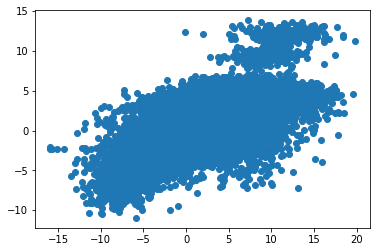

In [23]:
y = cadrres_output_dict['pred_test_df'].values.flatten()
x = cadrres_output_dict['obs_test_df'].values.flatten()
plt.scatter(x[~np.isnan(x)], y[~np.isnan(x)])

In [24]:
!ls {output_dir}

cadrres_5f_1_output_dict.pickle
cadrres_5f_1_param_dict.pickle
cadrres_5f_2_output_dict.pickle
cadrres_5f_2_param_dict.pickle
cadrres_5f_3_output_dict.pickle
cadrres_5f_3_param_dict.pickle
cadrres_5f_4_output_dict.pickle
cadrres_5f_4_param_dict.pickle
cadrres_5f_5_output_dict.pickle
cadrres_5f_5_param_dict.pickle
cadrres-wo-sample-bias-weight_5f_1_output_dict.pickle
cadrres-wo-sample-bias-weight_5f_1_param_dict.pickle
cadrres-wo-sample-bias-weight_5f_2_output_dict.pickle
cadrres-wo-sample-bias-weight_5f_2_param_dict.pickle
cadrres-wo-sample-bias-weight_5f_3_output_dict.pickle
cadrres-wo-sample-bias-weight_5f_3_param_dict.pickle
cadrres-wo-sample-bias-weight_5f_4_output_dict.pickle
cadrres-wo-sample-bias-weight_5f_4_param_dict.pickle
cadrres-wo-sample-bias-weight_5f_5_output_dict.pickle
cadrres-wo-sample-bias-weight_5f_5_param_dict.pickle
